In [ ]:
import warnings
import os
import logging
root_dir = os.path.abspath(".")

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

from models.data_container.plugin.patient_hana_ent import load

# --- Global style setup ---
sns.set_theme(style="white", context="notebook")
plt.rcParams.update({
    "font.size": 12,
    "axes.labelweight": "semibold",
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "figure.facecolor": "white",
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
})

In [2]:
og = load(root_dir)
demo = og[['id', 'date', 'sex', 'age']]

Loading inpatient data for 2018...
Loading inpatient data for 2019...
Loading inpatient data for 2020...
Loading inpatient data for 2021...
Loading inpatient data for 2022...
Loading inpatient data for 2023...
Loading inpatient data for 2024...
Loading outpatient data for 2018 Q1
Loading outpatient data for 2018 Q2
Loading outpatient data for 2018 Q3
Loading outpatient data for 2018 Q4
Loading outpatient data for 2019 Q1
Loading outpatient data for 2019 Q2
Loading outpatient data for 2019 Q3
Loading outpatient data for 2019 Q4
Loading outpatient data for 2020 Q1
Loading outpatient data for 2020 Q2
Loading outpatient data for 2020 Q3
Loading outpatient data for 2020 Q4
Loading outpatient data for 2021 Q1
Loading outpatient data for 2021 Q2
Loading outpatient data for 2021 Q3
Loading outpatient data for 2021 Q4
Loading outpatient data for 2022 Q1
Loading outpatient data for 2022 Q2
Loading outpatient data for 2022 Q3
Loading outpatient data for 2022 Q4
Loading outpatient data for 2023 Q1

In [3]:
# Get parquet files
f2_dep = pd.read_parquet("data/processed/hana_ent/f2_dep.parquet")
f3_dep = pd.read_parquet("data/processed/hana_ent/f3_dep.parquet")

f2_diag = pd.read_parquet("data/processed/hana_ent/f2_diag.parquet")
f3_diag = pd.read_parquet("data/processed/hana_ent/f3_diag.parquet")

f2_pres = pd.read_parquet("data/processed/hana_ent/f2_pres.parquet")
f3_pres = pd.read_parquet("data/processed/hana_ent/f3_pres.parquet")

meta_dep = pd.read_parquet("data/processed/hana_ent/meta_dep.parquet")
meta_diag = pd.read_parquet("data/processed/hana_ent/meta_diag.parquet")
meta_pres = pd.read_parquet("data/processed/hana_ent/meta_pres.parquet")

In [12]:
# Join the meta and vector data - 2D & 3D
dep_2d = meta_dep.join(f2_dep)
diag_2d = meta_diag.join(f2_diag)
pres_2d = meta_pres.join(f2_pres)

dep_3d = meta_dep.join(f3_dep)
diag_3d = meta_diag.join(f3_diag)
pres_3d = meta_pres.join(f3_pres)

In [21]:
mdf_2d = pd.merge(demo, dep_2d[['id', 'date', 'umap1', 'umap2']], on=['id', 'date'])
mdf_2d = pd.merge(mdf_2d, diag_2d[['id', 'date', 'umap1', 'umap2']], on=['id', 'date'])
mdf_2d = pd.merge(mdf_2d, pres_2d[['id', 'date', 'umap1', 'umap2']], on=['id', 'date'])
mdf_2d.set_index(['id', 'date'], inplace=True)
mdf_2d.drop_duplicates(inplace=True)

mdf_3d = pd.merge(demo, dep_3d[['id', 'date', 'umap1', 'umap2', 'umap3']], on=['id', 'date'])
mdf_3d = pd.merge(mdf_3d, diag_3d[['id', 'date', 'umap1', 'umap2', 'umap3']], on=['id', 'date'])
mdf_3d = pd.merge(mdf_3d, pres_3d[['id', 'date', 'umap1', 'umap2', 'umap3']], on=['id', 'date'])
mdf_3d.set_index(['id', 'date'], inplace=True)
mdf_3d.drop_duplicates(inplace=True)

In [47]:
mdf_2d.to_parquet("data/processed/hana_ent/mdf_2d.parquet")
mdf_3d.to_parquet("data/processed/hana_ent/mdf_3d.parquet")

In [ ]:
# 2D
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mdf_2d)

cluster_2d = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=70,
    metric='euclidean'
)
labels = cluster_2d.fit_predict(X_scaled)

Unique clusters: 9
Noise ratio (Department): 0.13%


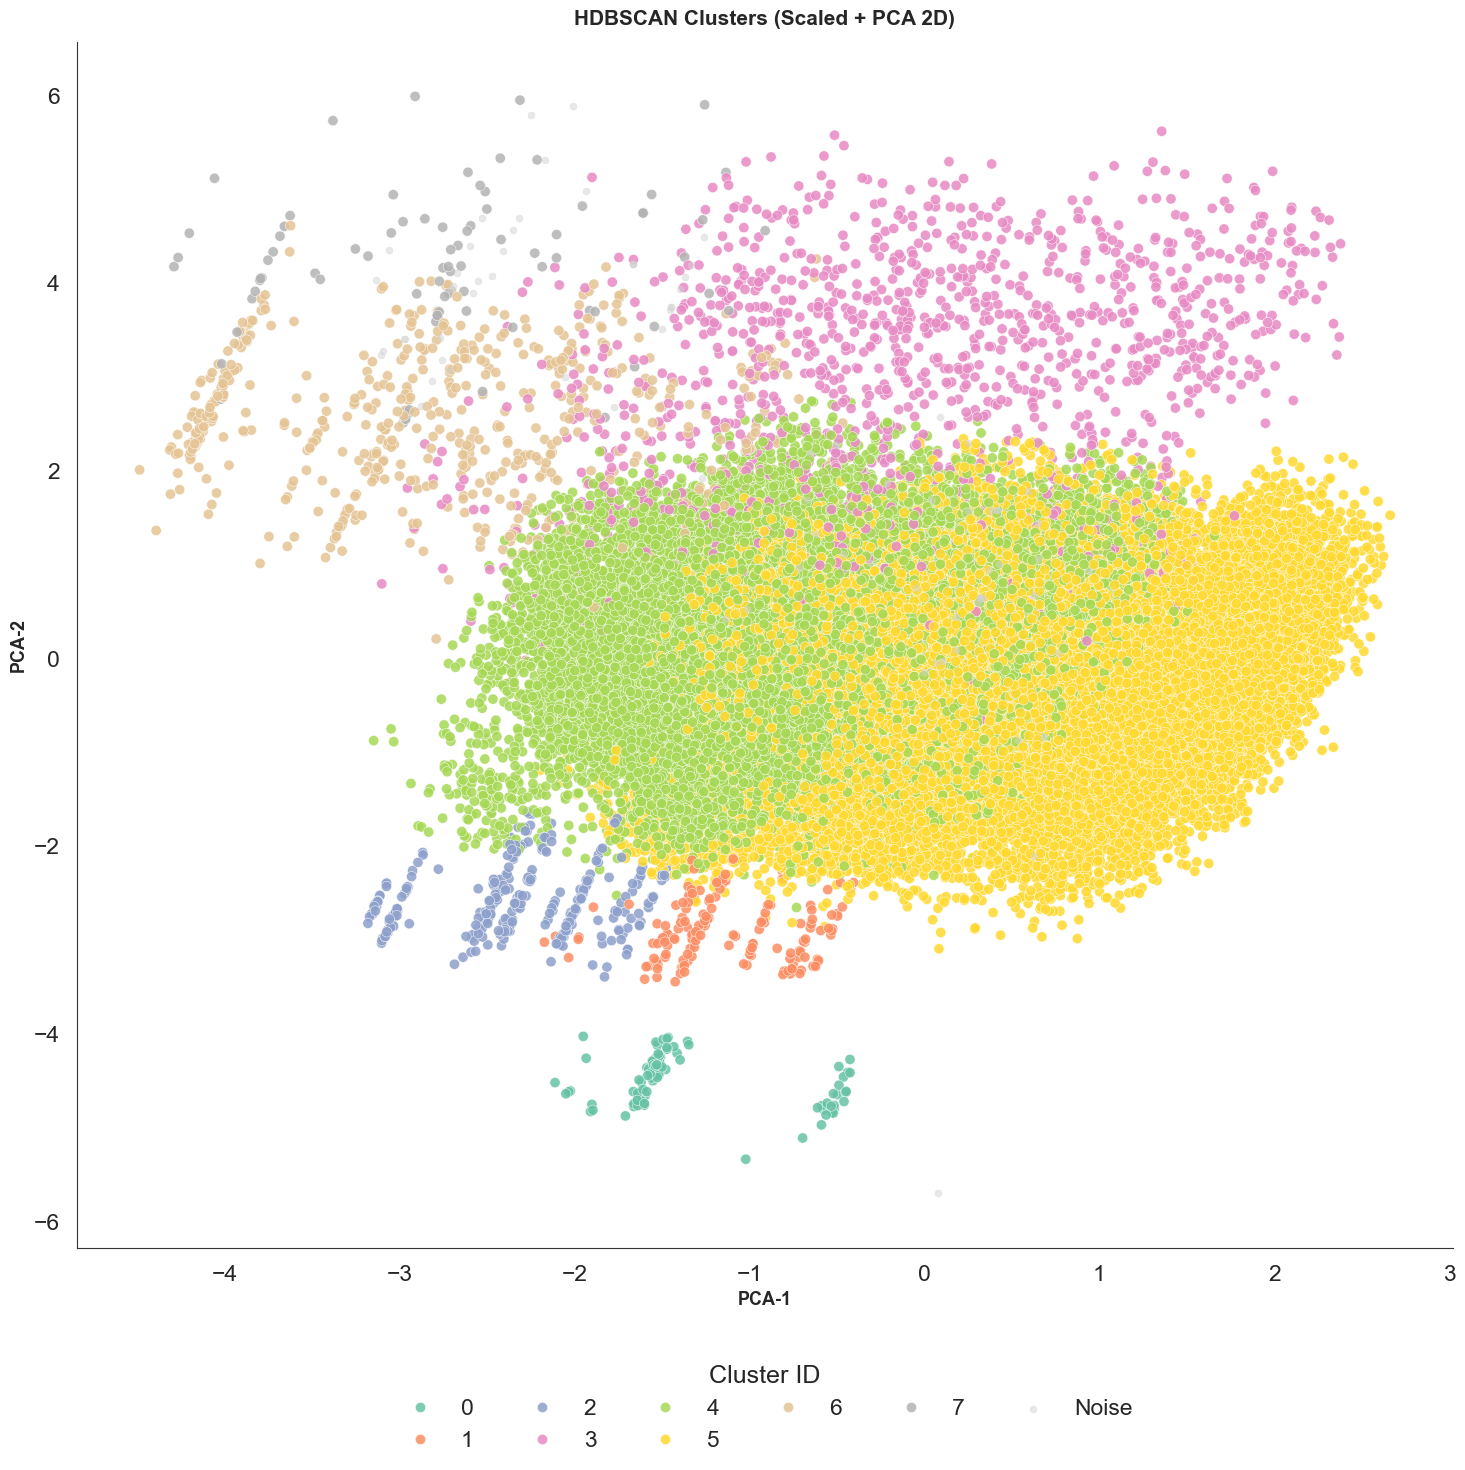

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Combine into DataFrame
c2d = pd.DataFrame(X_pca, columns=['PCA-1', 'PCA-2'], index=mdf_2d.index)
c2d['cluster_label'] = labels
mask = c2d['cluster_label'] != -1

print(f"Unique clusters: {len(np.unique(labels))}")
print(f"Noise ratio (Department): {(~mask).sum() / len(labels):.2%}")

plt.figure(figsize=(15, 15))
palette = sns.color_palette("Set2", len(np.unique(c2d.loc[mask, "cluster_label"])))
sns.scatterplot(
    data=c2d[mask],
    x='PCA-1',
    y='PCA-2',
    hue='cluster_label',
    palette=palette,
    s=55,
    alpha=0.85,
    edgecolor="white",
    linewidth=0.4
)

# Noise
sns.scatterplot(
    data=c2d[~mask],
    x='PCA-1',
    y='PCA-2',
    color="lightgray",
    s=25,
    alpha=0.5,
    label="Noise",
    edgecolor=None
)

plt.title("HDBSCAN Clusters (Scaled + PCA 2D)", pad=12)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

plt.legend(
    title="Cluster ID",
    bbox_to_anchor=(0.5, -0.08),
    loc="upper center",
    ncol=6,
    frameon=False
)
sns.despine()
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [ ]:
# 3D
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mdf_3d)

cluster_3d = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=70,
    metric='euclidean'
)
labels = cluster_3d.fit_predict(X_scaled)

Unique clusters: 9
Noise ratio (Department): 0.13%


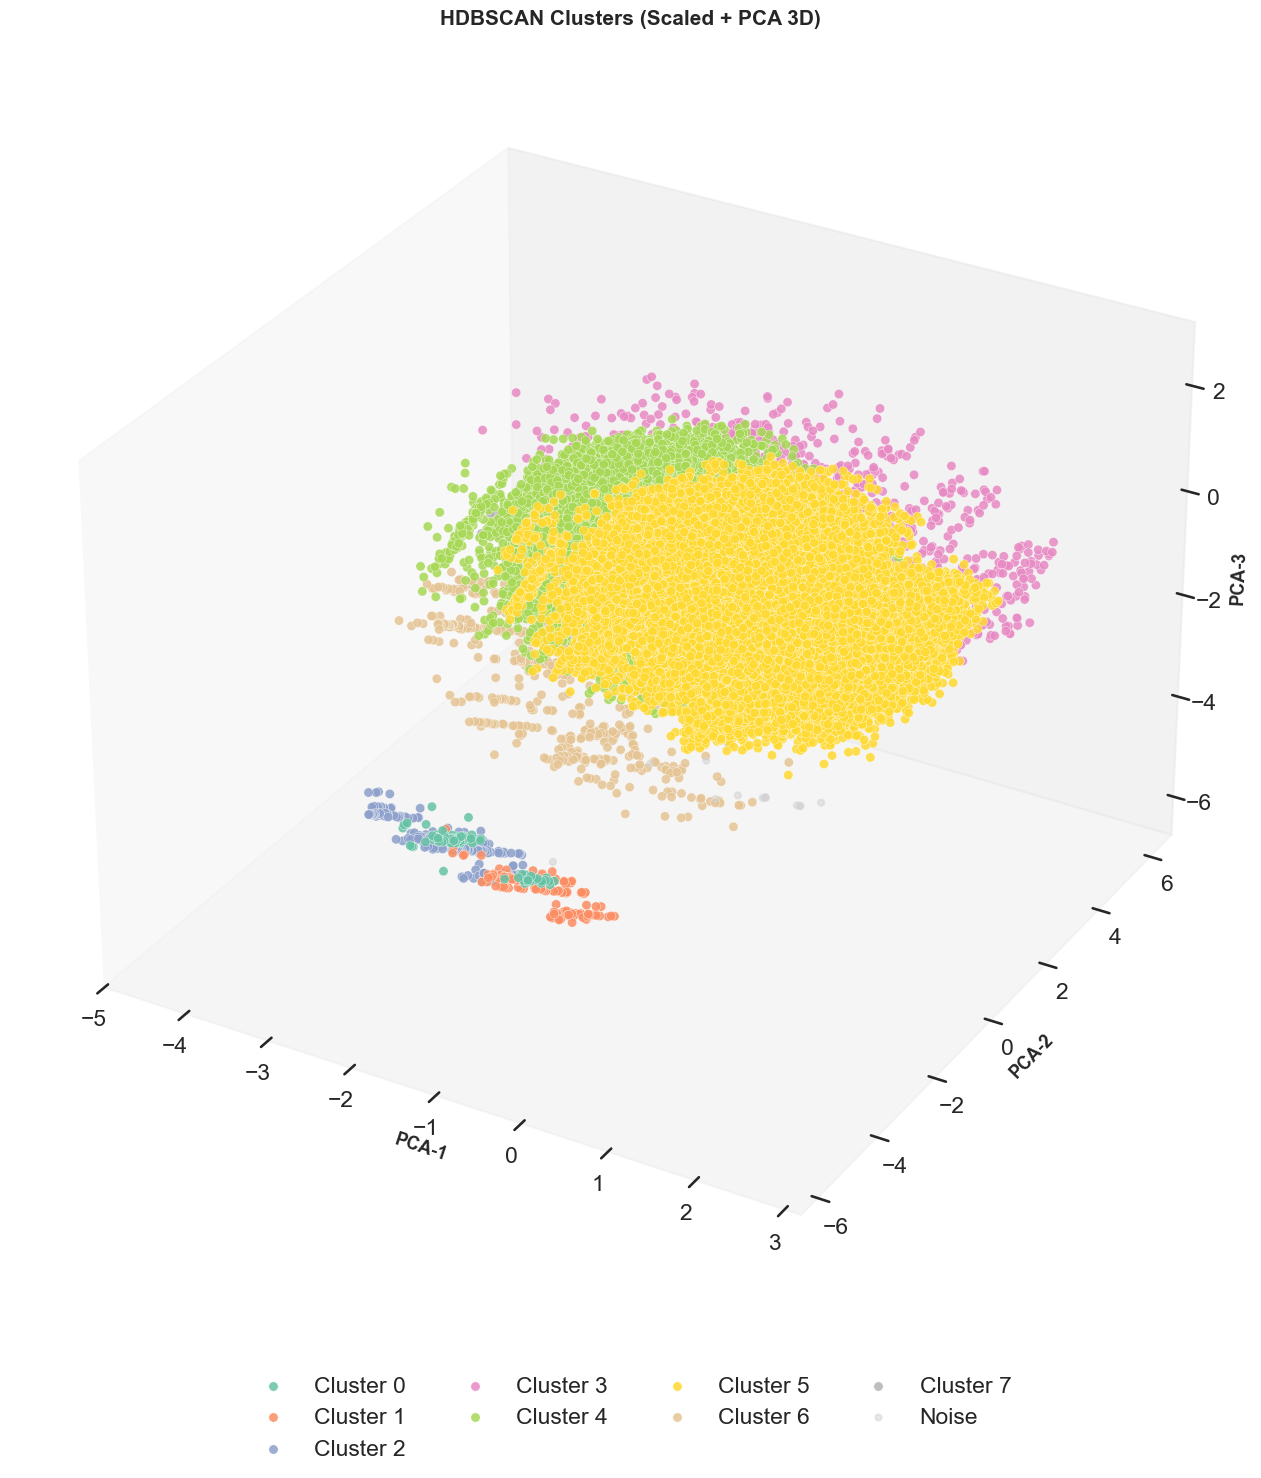

In [44]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Combine into DataFrame
c3d = pd.DataFrame(X_pca, columns=['PCA-1', 'PCA-2', 'PCA-3'], index=mdf_3d.index)
c3d['cluster_label'] = labels
mask = c3d['cluster_label'] != -1

print(f"Unique clusters: {len(np.unique(labels))}")
print(f"Noise ratio (Department): {(~mask).sum() / len(labels):.2%}")

# --- Mask for clusters (non-noise only) ---
mask = c3d["cluster_label"] != -1
num_clusters = len(np.unique(c3d.loc[mask, "cluster_label"]))

# --- 3D Plot Setup ---
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")

# Color palette
palette = sns.color_palette("Set2", num_clusters)

# Plot each cluster separately
for i, color in enumerate(palette):
    cluster_points = c3d[c3d["cluster_label"] == i]
    ax.scatter(
        cluster_points["PCA-1"],
        cluster_points["PCA-2"],
        cluster_points["PCA-3"],
        color=color,
        label=f"Cluster {i}",
        s=45,
        alpha=0.85,
        edgecolor="white",
        linewidth=0.3,
    )

# Plot noise (gray)
noise_points = c3d[~mask]
if not noise_points.empty:
    ax.scatter(
        noise_points["PCA-1"],
        noise_points["PCA-2"],
        noise_points["PCA-3"],
        color="lightgray",
        s=20,
        alpha=0.5,
        label="Noise",
    )

# --- Labels and Titles ---
ax.set_title("HDBSCAN Clusters (Scaled + PCA 3D)", pad=20)
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
ax.set_zlabel("PCA-3")

# --- Aesthetics ---
ax.grid(False)
ax.set_facecolor("white")
ax.xaxis.line.set_color((0, 0, 0, 0))
ax.yaxis.line.set_color((0, 0, 0, 0))
ax.zaxis.line.set_color((0, 0, 0, 0))

# --- Legend ---
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False,
)

plt.tight_layout()
plt.show()